In [48]:
import caffe
import leveldb
import numpy as np
from caffe.proto import caffe_pb2
import cPickle as pickle
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os

In [49]:
path = os.getcwd() + "/raw_pickle"
path

'/Users/DanielMinsuKim/Dropbox/perception_modeling/raw_pickle'

In [233]:
raw_pickles = [item for item in os.listdir(path) if item.endswith(".pickle")]
raw_pickles = raw_pickles[:1]
raw_pickles

['torcs_data_100000.pickle']

In [50]:
def remove_file(pickle_data):
    delte_file = path + "/" + pickle_data
    os.remove(delte_file)

In [51]:
def read_data_from_pickle(pickle_data):
    print("read raw pickle...")
    with open("raw_pickle/%s"%pickle_data, 'rb') as handle:
        data = pickle.load(handle)
        return data

In [52]:
def save_data_to_pickle(title, data):
    print("save to pickle...")
    with open("processed_pickle/%s"%title, 'wb') as handle:
        print("saving....")
        pickle.dump(data, handle, pickle.HIGHEST_PROTOCOL)
        print("saved!")

In [53]:
def datum_to_dict(data):
    datum = caffe_pb2.Datum()
    imgs = []
    labels = []
    print("convert datum to dictionary...")
    for item in data:

        key = str(item['key'])

        datum.ParseFromString(str(item['value']))
        data = caffe.io.datum_to_array(datum)
        image = np.transpose(data, (1,2,0))
        label = list(datum.float_data)
        
        img = {
            "key": key,
            "image": image
            
              }            
        label = {
            "key" : key,
            "label" : label
        }
        imgs.append(img)
        labels.append(label)

    return [imgs, labels]

In [54]:
def process_pickle(pickle_data):
    raw_pickle = read_data_from_pickle(pickle_data)
    processed_dict = datum_to_dict(raw_pickle)
    remove_file(pickle_data)
    save_data_to_pickle(pickle_data, processed_dict)

In [230]:
for raw_pickle in raw_pickles:
    print("raw_pickle")
    process_pickle(raw_pickle)

read raw pickle...
convert datum to dictionary...
save to pickle...
saving....
saved!


In [236]:
raw_pickle = read_data_from_pickle("torcs_data_310000.pickle")

read raw pickle...


In [ ]:
raw_pickle

In [200]:
processed_dict = datum_to_dict(raw_pickle)

In [201]:
save_data_to_pickle("torcs_data_10000.pickle", processed_dict)

saving....
saved!


In [55]:
# sanity check

with open("processed_pickle/torcs_data_10000.pickle", 'rb') as handle:
    sample = pickle.load(handle)

In [25]:
def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

In [7]:
tmp = sample[0][:400]

In [4]:
X = np.array([[0, 2, 2], [1, 1, 0], [2, 0, 1], [1, 3, 5], [10, 10, 10] ])

In [5]:
X

array([[ 0,  2,  2],
       [ 1,  1,  0],
       [ 2,  0,  1],
       [ 1,  3,  5],
       [10, 10, 10]])

In [29]:
ZCAMatrix = zca_whitening_matrix(X)

In [24]:
ZCAMatrix.shape

(5,)

In [30]:
X1 = np.dot(ZCAMatrix, X)

In [31]:
X1

array([[  166.86092451,   168.03246973,   167.61824734],
       [  501.66561302,   501.99699093,   501.16268489],
       [  280.15676051,   278.65383738,   279.90236581],
       [  112.21299652,   112.72178592,   113.97617561],
       [ 3162.27766017,  3162.27766017,  3162.27766017]])

In [14]:
a = [flatten_matrix(item['image'][:,:,0]) for item in tmp]
matrix = np.vstack(a)
matrix

/Users/DanielMinsuKim/anaconda/envs/caffe2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  from ipykernel import kernelapp as app


array([[149, 138, 137, ...,  90,  91,  91],
       [153, 108, 163, ...,  88,  89,  86],
       [128, 172, 107, ...,  90,  86,  86],
       ..., 
       [179, 180, 180, ...,  35,  39,  32],
       [177, 179, 180, ...,  38,  45,  46],
       [177, 177, 176, ...,  44,  58,  35]], dtype=uint8)

In [32]:
ZCAMatrix = zca_whitening_matrix(matrix)

In [33]:
X1 = np.dot(ZCAMatrix, matrix)

In [34]:
X1

array([[ 0.11956059,  0.63209428, -1.25908934, ...,  0.21208531,
         0.29475514,  0.35270997],
       [ 1.12263085, -3.70237203,  2.64237911, ...,  0.08398314,
         0.31522608,  0.01881836],
       [-1.94418364,  4.41272345, -5.07162831, ...,  0.47089914,
        -0.07799021,  0.17672092],
       ..., 
       [ 0.12854677,  0.20105042,  0.10087217, ..., -0.58333147,
        -0.54153411, -0.80454242],
       [ 0.02770472,  0.25658078,  0.24161632, ..., -0.53673075,
        -0.42762758, -0.05790189],
       [ 0.2405267 ,  0.30947572,  0.12847342, ..., -0.39572591,
         0.20078458, -0.8262326 ]])

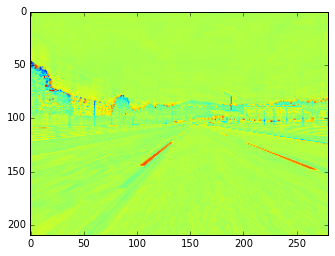

In [47]:
plt.imshow(X1[311].reshape(280, 210).T)
# plt.imshow()

In [13]:


# np.asmatrix(a)

In [145]:
matrix.shape

(400, 58800)

In [ ]:
b = zca_whitening(matrix.T)

In [ ]:
b

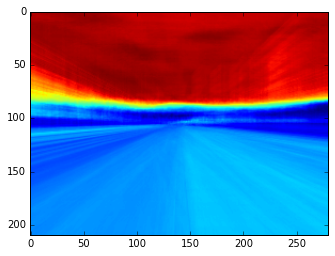

In [141]:
plt.imshow(b.reshape(280, 210).T)

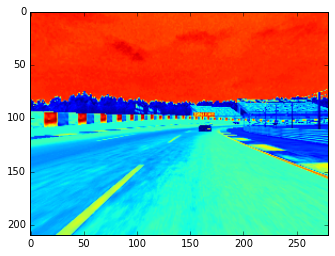

In [106]:
plt.imshow(sample[0][380]['image'][:,:,0])

In [9]:
def flatten_matrix(matrix):
    vector = matrix.flatten(1)
    vector = vector.reshape(1, len(vector))
    return vector

In [10]:
def zca_whitening(inputs):
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 0.1                #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     #ZCA Whitening matrix
    return np.dot(ZCAMatrix, inputs)   #Data whitening

In [67]:
tmp.shape

(210, 280, 3)

In [19]:
tmp2 = flatten_matrix(tmp)

/Users/DanielMinsuKim/anaconda/envs/caffe2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  from ipykernel import kernelapp as app


In [20]:
tmp2

array([[180, 179, 178, ...,  93,  90,  86]], dtype=uint8)

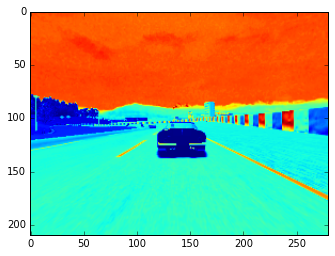

In [80]:
plt.imshow(tmp[:,:,0])

In [68]:
tmp2 = flatten_matrix(tmp[:,:,0])
tmp2.shape

/Users/DanielMinsuKim/anaconda/envs/caffe2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  from ipykernel import kernelapp as app


(1, 58800)

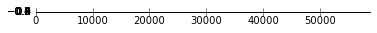

In [57]:
plt.imshow(tmp2)

In [59]:
tmp3 = zca_whitening(tmp2)

In [60]:
tmp3

array([ 569.20997883,  566.04770117,  562.88542351, ...,  294.0918224 ,
        284.60498942,  278.28043409])

In [71]:
tmp3.shape

(58800,)

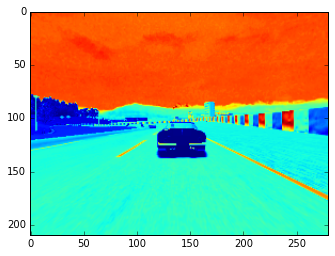

In [78]:
plt.imshow(tmp3.reshape(280, 210).T)